# Import packages

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, f1_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms
from tqdm import tqdm
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from huggingface_hub import HfApi, login, HfFolder
login()

In [ ]:
from torchmetrics import Accuracy, Precision, Recall, F1Score
import time
import wandb

API-KEY = ""
wandb.login(key=API-KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mandour (mandour-cairo-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# SEED for reproducability

In [ ]:
# Set random seed for reproducibility
seed = 10
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Import Data from Hugging face

In [ ]:
from huggingface_hub import hf_hub_download
import zipfile
import os

def download_and_extract_zip(repo_id, file_name, output_dir, repo_type="dataset"):
    """
    Downloads a zip file from a Hugging Face repository and extracts its contents.

    Args:
        repo_id (str): The repository ID in the form 'namespace/repo_name'.
        file_name (str): The name of the zip file in the repository.
        output_dir (str): Directory to extract the contents of the zip file.
        repo_type (str): The type of the repository ('model', 'dataset', or 'space').
    """
    # Download the zip file
    zip_file_path = hf_hub_download(repo_id=repo_id, filename=file_name, repo_type=repo_type)
    print(f"Downloaded '{file_name}' from '{repo_id}' to '{zip_file_path}'.")

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print(f"Extracted contents to '{output_dir}'.")

# Example usage
repo_id = ...
file_name = ...
output_dir = ...

download_and_extract_zip(repo_id, file_name, output_dir)


output.zip:   0%|          | 0.00/13.2G [00:00<?, ?B/s]

Downloaded 'output.zip' from 'Mandour-101/Strip-img-resized-224' to '/root/.cache/huggingface/hub/datasets--Mandour-101--Strip-img-resized-224/snapshots/6c6db3881b805ba8f407c09809607d596f214d36/output.zip'.
Extracted contents to '/kaggle/working/unzipped_files'.


# Create dataframe and Pipeline

In [ ]:
df_valid = pd.read_csv("/kaggle/input/valid-data2/valid_imagesV2.csv")
df_valid

,path,label
0,/kaggle/working/unzipped_files/LAA/fbdcde_1_19...,1
1,/kaggle/working/unzipped_files/LAA/f83bf0_0_16...,1
2,/kaggle/working/unzipped_files/LAA/6baf51_0_14...,1
3,/kaggle/working/unzipped_files/LAA/c9ab6c_0_5_...,1
4,/kaggle/working/unzipped_files/LAA/fbdcde_0_28...,1
...,...,...
118631,/kaggle/working/unzipped_files/CE/dc8f86_1_1_1...,0
118632,/kaggle/working/unzipped_files/CE/cb2534_1_10_...,0
118633,/kaggle/working/unzipped_files/CE/f58fcb_0_23_...,0
118634,/kaggle/working/unzipped_files/CE/f57f2e_0_15_...,0


In [ ]:
# Function to plot random samples with labels
def plot_random_samples(df, num_samples=5):
    # Randomly sample 'num_samples' rows from the dataframe
    sampled_df = df.sample(n=num_samples)

    # Set up the plot grid (e.g., 1 row, num_samples columns)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Loop through the sampled images and display them
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['path']
        label = row['label']

        # Load and display the image
        image = Image.open(image_path).convert('RGB')
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis

        # Set title with label
        axes[i].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

plot_random_samples(df_valid, num_samples=5)

## Splitting data to train, val, and test

In [ ]:
df_train, df_temp = train_test_split(df_valid, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

## Create Dataset and Dataloaders

In [ ]:
class ImageDataset(Dataset):
   def __init__(self, df, transform=None):
       self.df = df
       self.transform = transform or transforms.Compose([
           transforms.Resize((224, 224)),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
       ])

   def __len__(self):
       return len(self.df)

   def __getitem__(self, idx):
       img_path = self.df.iloc[idx]["path"]
       label = self.df.iloc[idx]["label"]

       image = Image.open(img_path).convert("RGB")
       image = self.transform(image)
       return image, torch.tensor(label, dtype=torch.long)

## Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.2, hue=0.3, saturation=0.3),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Train loader:
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


In [ ]:
# Create datasets
train_dataset = ImageDataset(df_train, transform= train_transform)
val_dataset = ImageDataset(df_val, transform= val_test_transform)
test_dataset = ImageDataset(df_test, transform= val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

for images, labels in train_loader:
    print("Train loader:")
    print(f"Image batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break  # Only print for the first batch, to avoid printing too much

## Class count for imbalance in the data

In [ ]:
# Count the occurrences of each class
class_counts = df_valid['label'].value_counts()

# Total number of samples
total_samples = len(df_valid)

# Calculate weights as inverse frequency
class_weights = total_samples / class_counts

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

# Map weights to class indices
class_to_weight = dict(zip(class_counts.index, class_weights))
print("Class Weights Mapping:", class_to_weight)
print("PyTorch Class Weights Tensor:", class_weights_tensor)

Class Weights Mapping: {0: 1.531696232602577, 1: 2.8807731533194114}
PyTorch Class Weights Tensor: tensor([1.5317, 2.8808])


# Models

## PoolFormer class Wrapper

In [ ]:
from timm import create_model

def create_optimized_poolformer36_model(num_classes=2, dropout_rate=0.3, trainable_backbone_layers=10):
    """
    Creates a Poolformer model with improvements for better performance and reduced overfitting.

    Args:
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate for the classifier head.
        trainable_backbone_layers (int): Number of trainable backbone layers from the end.
        use_label_smoothing (bool): Whether to apply label smoothing.

    Returns:
        nn.Module: Optimized Poolformer model ready for fine-tuning.
    """
    # Create the base Poolformer model
    model = create_model('poolformer_s36', pretrained=True)

    # Freeze all layers by default
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last `trainable_backbone_layers` stages in the backbone
    if hasattr(model, "stages"):
        for stage in model.stages[-trainable_backbone_layers:]:
            for param in stage.parameters():
                param.requires_grad = True
    else:
        raise AttributeError("The Poolformer model does not have the expected 'stages' attribute.")

    # Modify the classifier head
    if hasattr(model.head, "fc"):  # Access the fully connected layer in the head
        in_features = model.head.fc.in_features
        model.head.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, in_features // 2),  # Intermediate dense layer
            nn.ReLU(),
            nn.BatchNorm1d(in_features // 2),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features // 2, num_classes)
        )
    else:
        raise AttributeError("The Poolformer model does not have the expected 'fc' in the head.")

    # Ensure classifier head is trainable
    for param in model.head.parameters():
        param.requires_grad = True


    return model


# Hyperparameters
num_classes = 2
dropout_rate = 0.5  # Increased dropout rate to reduce overfitting
trainable_backbone_layers = 12 # Fine-tune more layers in the backbone

# Create the optimized model
model = create_optimized_poolformer36_model(
    num_classes=num_classes,
    dropout_rate=dropout_rate,
    trainable_backbone_layers=trainable_backbone_layers,).to(device)

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

In [ ]:
class TrainerConfig:
    def __init__(self):
        self.num_classes = 2
        self.patience = 3
        self.min_delta = 1e-4
        self.plot_interval = 2
        self.max_grad_norm = 1.0
        self.early_stop_metric = 'loss'
        self.learning_rate = 3e-4
        self.weight_decay = 1e-5

## Loss function $WMCLL$

In [ ]:
class WeightedMultiClassLogLoss(nn.Module):
    def __init__(self, class_weights=None, device=None):
        """
        Initializes the Weighted Multi-Class Log Loss (WMCLL).

        Args:
            class_weights (torch.Tensor): A tensor of shape (num_classes,) containing weights for each class.
            device (torch.device): The device to perform the computation on.
        """
        super().__init__()
        self.device = device if device else torch.device('cpu')
        self.class_weights = class_weights.to(self.device) if class_weights is not None else None

    def forward(self, logits, targets):
        """
        Computes the Weighted Multi-Class Log Loss.

        Args:
            logits (torch.Tensor): Predicted logits of shape (batch_size, num_classes).
            targets (torch.Tensor): Ground truth of shape (batch_size, num_classes) as one-hot encoded.

        Returns:
            torch.Tensor: The computed weighted multi-class log loss.
        """
        logits, targets = logits.to(self.device), targets.to(self.device)

        if self.class_weights is not None:
            weights = self.class_weights.to(self.device)
        else:
            weights = torch.ones(logits.size(1), device=self.device)

        probs = torch.softmax(logits, dim=1)
        log_probs = torch.log(probs + 1e-8)
        weighted_log_loss = -torch.sum(weights * targets * log_probs, dim=1)
        loss = torch.mean(weighted_log_loss)

        return loss

## Trainer Class

In [ ]:
class Trainer:
    def __init__(self, model, criterion, config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = criterion
        self.config = config

        # Initialize optimizer and scheduler
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=2,
            factor=0.5,
            min_lr=1e-6
        )

        # Initialize metrics with macro averaging
        self.metrics = {
            'accuracy': Accuracy(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'precision': Precision(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'recall': Recall(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'f1': F1Score(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device)
        }

        # Initialize training state
        self.best_model = None
        self.best_metric = float('inf') if self.config.early_stop_metric == 'loss' else float('-inf')
        self.history = {'train': [], 'val': []}
        self.epochs_without_improve = 0

        # Initialize W&B
        self.run = wandb.init(
            project=config.project_name,
            config={
                "learning_rate": config.learning_rate,
                "weight_decay": config.weight_decay,
                "batch_size": config.batch_size,
                "epochs": config.epochs,
                "model": model.__class__.__name__
            }
        )
        wandb.watch(model)

    def reset_metrics(self):
        """Reset all metrics at the start of each epoch"""
        for metric in self.metrics.values():
            metric.reset()

    def validate(self, val_loader):
        """Validate the model on the validation set"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        self.reset_metrics()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                batch_size = inputs.size(0)
                total_samples += batch_size

                outputs = self.model(inputs)
                one_hot = nn.functional.one_hot(labels, self.config.num_classes).float()
                total_loss += self.criterion(outputs, one_hot).item() * batch_size

                preds = outputs.argmax(1)
                for metric in self.metrics.values():
                    metric.update(preds, labels)

        metrics_dict = {
            'loss': total_loss / total_samples,
            'accuracy': self.metrics['accuracy'].compute().item(),
            'precision': self.metrics['precision'].compute().item(),
            'recall': self.metrics['recall'].compute().item(),
            'f1': self.metrics['f1'].compute().item()
        }
        wandb.log({f"val_{k}": v for k, v in metrics_dict.items()})
        return metrics_dict

    def train_epoch(self, train_loader, epoch_idx):
        """Train for one epoch and log metrics against batches."""
        self.model.train()
        total_loss = 0
        total_samples = 0
        self.reset_metrics()

        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch_idx + 1}")):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            batch_size = inputs.size(0)
            total_samples += batch_size

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            one_hot = nn.functional.one_hot(labels, self.config.num_classes).float()
            loss = self.criterion(outputs, one_hot)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * batch_size
            preds = outputs.argmax(1)
            for metric in self.metrics.values():
                metric.update(preds, labels)

            # Compute batch metrics
            batch_metrics = {
                'loss': loss.item(),
                'accuracy': self.metrics['accuracy'].compute().item(),
                'precision': self.metrics['precision'].compute().item(),
                'recall': self.metrics['recall'].compute().item(),
                'f1': self.metrics['f1'].compute().item()
            }

            # Log metrics to W&B
            wandb.log({f"train_batch_{k}": v for k, v in batch_metrics.items()}, step=epoch_idx * len(train_loader) + batch_idx)

        # Compute epoch-level metrics
        epoch_metrics = {
            'loss': total_loss / total_samples,
            'accuracy': self.metrics['accuracy'].compute().item(),
            'precision': self.metrics['precision'].compute().item(),
            'recall': self.metrics['recall'].compute().item(),
            'f1': self.metrics['f1'].compute().item()
        }
        wandb.log({f"train_epoch_{k}": v for k, v in epoch_metrics.items()}, step=epoch_idx + 1)

        return epoch_metrics

    def train(self, train_loader, val_loader, epochs=10):
        """Main training loop"""
        print(f"Starting training on device: {self.device}")
        start_time = time.time()

        for epoch in range(epochs):
            epoch_start = time.time()

            # Training phase
            train_metrics = self.train_epoch(train_loader, epoch)

            # Validation phase
            val_metrics = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step(val_metrics['loss'])

            # Store history
            self.history['train'].append(train_metrics)
            self.history['val'].append(val_metrics)

            # Print progress
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch + 1}/{epochs} - Time: {epoch_time:.2f}s")
            print("Train:", " ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))
            print("Val:", " ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))

            # Check for improvement
            current = val_metrics[self.config.early_stop_metric]
            improved = (self.config.early_stop_metric == 'loss' and
                       current < self.best_metric - self.config.min_delta) or \
                      (self.config.early_stop_metric != 'loss' and
                       current > self.best_metric + self.config.min_delta)

            if improved:
                self.best_metric = current
                self.best_model = self.model.state_dict().copy()
                self.epochs_without_improve = 0
                print(f"Best {self.config.early_stop_metric}: {self.best_metric:.4f}")
                torch.save(self.model.state_dict(), f"best_model_epoch_{epoch + 1}.pth")
            else:
                self.epochs_without_improve += 1
                if self.epochs_without_improve >= self.config.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Training completed
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f}s")

        # Restore best model
        self.model.load_state_dict(self.best_model)
        wandb.save("best_model.pth")

        return self.model


    def plot_metrics(self, final=False):
        """Plot training metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'f1']
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for ax, metric in zip(axes, metrics):
            train_metric = [epoch[metric] for epoch in self.history['train']]
            val_metric = [epoch[metric] for epoch in self.history['val']]
            ax.plot(train_metric, label='Train')
            ax.plot(val_metric, label='Val')

            ax.set_title(f'{metric.capitalize()}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.capitalize())
            ax.legend()
            ax.grid(True)

        plt.tight_layout()

        if final:
            plt.savefig('training_metrics.png')
            plt.show()
        else:
            plt.draw()
            plt.pause(0.1)
        plt.close(fig)

    def plot_confusion_matrix(self, loader, title="Confusion Matrix"):
        """Plot confusion matrix on a given dataset (train/val/test)"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                preds = outputs.argmax(1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_preds, labels=np.arange(self.config.num_classes))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(self.config.num_classes))

        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax, cmap="Blues", values_format='d')
        plt.title(title)
        plt.savefig(f"{title.replace(' ', '_').lower()}.png")
        plt.show()

        # Log confusion matrix to W&B
        wandb.log({title: wandb.Image(fig)})
        plt.close(fig)


In [ ]:
# Create configuration
config = TrainerConfig()
config.num_classes = 2
config.patience = 5
config.learning_rate = 1e-4
config.weight_decay = 1e-5

criterion = WeightedMultiClassLogLoss(class_weights=class_weights_tensor)

# Create trainer
trainer = Trainer(model, criterion, config)

# Train the model
trained_model = trainer.train(train_loader, val_loader, epochs=20)

## CCT Model

In [ ]:
!git clone https://github.com/SHI-Labs/Compact-Transformers.git

Cloning into 'Compact-Transformers'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 450 (delta 131), reused 109 (delta 105), pack-reused 275 (from 1)
Receiving objects: 100% (450/450), 1.34 MiB | 5.02 MiB/s, done.
Resolving deltas: 100% (243/243), done.


In [ ]:
!mv /kaggle/working/Compact-Transformers /kaggle/working/Compact_Transformers

In [ ]:
# Change to a specific directory
os.chdir('/kaggle/working/Compact_Transformers')

# Verify the change
print(f"New Current Directory: {os.getcwd()}")

New Current Directory: /kaggle/working/Compact_Transformers


### CCT Class Wrapper

In [ ]:
class BinaryCCTWrapper(nn.Module):
    def __init__(self, base_model, freeze_layers=True, dropout_rate=0.3, trainble_layers=5):
        super().__init__()
        self.base_model = base_model

        if freeze_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False
        else:
            for param in self.base_model.parameters():
                param.requires_grad = False

            for block in self.base_model.classifier.blocks[-trainble_layers:]:
                for param in block.parameters():
                    param.requires_grad = True

            for param in self.base_model.classifier.norm.parameters():
                param.requires_grad = True

        in_features = self.base_model.classifier.fc.in_features

        # Replace base model's classifier head
        self.base_model.classifier.fc = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Linear(in_features, in_features * 2),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features * 2, in_features),
            nn.LayerNorm(in_features),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

In [ ]:
from src.cct import cct_14_7x2_224
# Instantiate the base CCT model
base_model = cct_14_7x2_224(img_size=224, pretrained=True, progress=True)

model = BinaryCCTWrapper(base_model=base_model, freeze_layers=False, dropout_rate=0.3)
model

/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
Downloading: "https://shi-labs.com/projects/cct/checkpoints/pretrained/cct_14_7x2_224_imagenet.pth" to /root/.cache/torch/hub/checkpoints/cct_14_7x2_224_imagenet.pth
100%|██████████| 85.4M/85.4M [00:05<00:00, 15.4MB/s]


BinaryCCTWrapper(
  (base_model): CCT(
    (tokenizer): Tokenizer(
      (conv_layers): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(64, 384, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): ReLU()
          (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
      )
      (flattener): Flatten(start_dim=2, end_dim=3)
    )
    (classifier): TransformerClassifier(
      (attention_pool): Linear(in_features=384, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): TransformerEncoderLayer(
          (pre_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
          (self_attn): Attention(
            (qkv

In [ ]:
class TrainerConfig:
    def __init__(self):
        self.num_classes = 2
        self.patience = 3
        self.min_delta = 1e-3
        self.plot_interval = 2
        self.max_grad_norm = 1.0
        self.early_stop_metric = 'loss'
        self.learning_rate = 3e-4
        self.weight_decay = 1e-5
        self.project_name = "CCT-CLOT-Classifier"
        self.run_name = "finetuning-runV2"
        self.batch_size=32
        self.epochs = 20

In [ ]:
# Create configuration
config = TrainerConfig()
config.num_classes = 2
config.patience = 5
config.learning_rate = 1e-4
config.weight_decay = 1e-5
config.run_name = "finetuning-run-temp1"
config.project_name = "CCT-CLOT-ClassifierV4"

criterion = WeightedMultiClassLogLoss(class_weights=class_weights_tensor)

# Create trainer
trainer = Trainer(model, criterion, config)


In [ ]:
num_epochs = 10
trained_model = trainer.train(train_loader, val_loader, epochs=num_epochs)

Starting training on device: cuda


Training Epoch 1:   0%|          | 0/2966 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epoch 1: 100%|██████████| 2966/2966 [07:54<00:00,  6.25it/s]
wandb: WARNING Tried to log to step 1 that is less than the current step 2965. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 1/40 - Time: 506.80s
Train: loss: 1.2698 accuracy: 0.6321 precision: 0.6207 recall: 0.6321 f1: 0.6191
Val: loss: 1.1634 accuracy: 0.6876 precision: 0.6746 recall: 0.6876 f1: 0.6767
Best loss: 1.1634


Training Epoch 2: 100%|██████████| 2966/2966 [07:38<00:00,  6.47it/s]
wandb: WARNING Tried to log to step 2 that is less than the current step 5931. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 2/40 - Time: 491.34s
Train: loss: 1.1740 accuracy: 0.6804 precision: 0.6668 recall: 0.6804 f1: 0.6687
Val: loss: 1.1482 accuracy: 0.6959 precision: 0.7129 recall: 0.6959 f1: 0.7019
Best loss: 1.1482


Training Epoch 3: 100%|██████████| 2966/2966 [07:37<00:00,  6.49it/s]
wandb: WARNING Tried to log to step 3 that is less than the current step 8897. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 3/40 - Time: 490.21s
Train: loss: 1.1263 accuracy: 0.7007 precision: 0.6859 recall: 0.7007 f1: 0.6885
Val: loss: 1.0587 accuracy: 0.7259 precision: 0.7314 recall: 0.7259 f1: 0.7284
Best loss: 1.0587


Training Epoch 4: 100%|██████████| 2966/2966 [07:36<00:00,  6.50it/s]
wandb: WARNING Tried to log to step 4 that is less than the current step 11863. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 4/40 - Time: 488.95s
Train: loss: 1.0883 accuracy: 0.7135 precision: 0.6979 recall: 0.7135 f1: 0.7011
Val: loss: 1.0657 accuracy: 0.7283 precision: 0.7545 recall: 0.7283 f1: 0.7371


Training Epoch 5: 100%|██████████| 2966/2966 [07:36<00:00,  6.50it/s]
wandb: WARNING Tried to log to step 5 that is less than the current step 14829. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 5/40 - Time: 489.44s
Train: loss: 1.0560 accuracy: 0.7258 precision: 0.7102 recall: 0.7258 f1: 0.7140
Val: loss: 1.0313 accuracy: 0.7469 precision: 0.7578 recall: 0.7469 f1: 0.7515
Best loss: 1.0313


Training Epoch 6: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 6 that is less than the current step 17795. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 6/40 - Time: 488.37s
Train: loss: 1.0253 accuracy: 0.7378 precision: 0.7221 recall: 0.7378 f1: 0.7263
Val: loss: 0.9626 accuracy: 0.7616 precision: 0.7506 recall: 0.7616 f1: 0.7548
Best loss: 0.9626


Training Epoch 7: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 7 that is less than the current step 20761. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 7/40 - Time: 488.67s
Train: loss: 1.0000 accuracy: 0.7458 precision: 0.7297 recall: 0.7458 f1: 0.7341
Val: loss: 0.9456 accuracy: 0.7658 precision: 0.7520 recall: 0.7658 f1: 0.7567
Best loss: 0.9456


Training Epoch 8: 100%|██████████| 2966/2966 [07:36<00:00,  6.49it/s]
wandb: WARNING Tried to log to step 8 that is less than the current step 23727. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 8/40 - Time: 489.42s
Train: loss: 0.9739 accuracy: 0.7549 precision: 0.7384 recall: 0.7549 f1: 0.7431
Val: loss: 0.9192 accuracy: 0.7753 precision: 0.7604 recall: 0.7753 f1: 0.7654
Best loss: 0.9192


Training Epoch 9: 100%|██████████| 2966/2966 [07:36<00:00,  6.50it/s]
wandb: WARNING Tried to log to step 9 that is less than the current step 26693. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 9/40 - Time: 489.60s
Train: loss: 0.9522 accuracy: 0.7626 precision: 0.7449 recall: 0.7626 f1: 0.7498
Val: loss: 0.8935 accuracy: 0.7850 precision: 0.7738 recall: 0.7850 f1: 0.7783
Best loss: 0.8935


Training Epoch 10: 100%|██████████| 2966/2966 [07:35<00:00,  6.52it/s]
wandb: WARNING Tried to log to step 10 that is less than the current step 29659. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 10/40 - Time: 488.05s
Train: loss: 0.9313 accuracy: 0.7687 precision: 0.7513 recall: 0.7687 f1: 0.7564
Val: loss: 0.8832 accuracy: 0.7846 precision: 0.7672 recall: 0.7846 f1: 0.7724
Best loss: 0.8832


Training Epoch 11: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 11 that is less than the current step 32625. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 11/40 - Time: 488.54s
Train: loss: 0.9124 accuracy: 0.7763 precision: 0.7583 recall: 0.7763 f1: 0.7636
Val: loss: 0.8629 accuracy: 0.7924 precision: 0.7804 recall: 0.7924 f1: 0.7851
Best loss: 0.8629


Training Epoch 12: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 12 that is less than the current step 35591. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 12/40 - Time: 488.14s
Train: loss: 0.8864 accuracy: 0.7834 precision: 0.7664 recall: 0.7834 f1: 0.7719
Val: loss: 0.8869 accuracy: 0.7887 precision: 0.7752 recall: 0.7887 f1: 0.7802


Training Epoch 13: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 13 that is less than the current step 38557. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 13/40 - Time: 488.11s
Train: loss: 0.8701 accuracy: 0.7890 precision: 0.7723 recall: 0.7890 f1: 0.7779
Val: loss: 0.8303 accuracy: 0.8041 precision: 0.7932 recall: 0.8041 f1: 0.7977
Best loss: 0.8303


Training Epoch 14: 100%|██████████| 2966/2966 [07:34<00:00,  6.53it/s]
wandb: WARNING Tried to log to step 14 that is less than the current step 41523. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 14/40 - Time: 487.03s
Train: loss: 0.8561 accuracy: 0.7937 precision: 0.7762 recall: 0.7937 f1: 0.7820
Val: loss: 0.8631 accuracy: 0.7954 precision: 0.7989 recall: 0.7954 f1: 0.7971


Training Epoch 15: 100%|██████████| 2966/2966 [07:34<00:00,  6.52it/s]
wandb: WARNING Tried to log to step 15 that is less than the current step 44489. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 15/40 - Time: 487.33s
Train: loss: 0.8425 accuracy: 0.7988 precision: 0.7817 recall: 0.7988 f1: 0.7875
Val: loss: 0.8214 accuracy: 0.8014 precision: 0.7952 recall: 0.8014 f1: 0.7980
Best loss: 0.8214


Training Epoch 16: 100%|██████████| 2966/2966 [07:34<00:00,  6.52it/s]
wandb: WARNING Tried to log to step 16 that is less than the current step 47455. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 16/40 - Time: 487.44s
Train: loss: 0.8268 accuracy: 0.8013 precision: 0.7839 recall: 0.8013 f1: 0.7898
Val: loss: 0.7949 accuracy: 0.8136 precision: 0.8110 recall: 0.8136 f1: 0.8123
Best loss: 0.7949


Training Epoch 17: 100%|██████████| 2966/2966 [07:34<00:00,  6.53it/s]
wandb: WARNING Tried to log to step 17 that is less than the current step 50421. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 17/40 - Time: 486.88s
Train: loss: 0.8091 accuracy: 0.8068 precision: 0.7893 recall: 0.8068 f1: 0.7953
Val: loss: 0.8033 accuracy: 0.8120 precision: 0.8025 recall: 0.8120 f1: 0.8066


Training Epoch 18: 100%|██████████| 2966/2966 [07:34<00:00,  6.53it/s]
wandb: WARNING Tried to log to step 18 that is less than the current step 53387. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 18/40 - Time: 487.21s
Train: loss: 0.7976 accuracy: 0.8107 precision: 0.7933 recall: 0.8107 f1: 0.7994
Val: loss: 0.7926 accuracy: 0.8163 precision: 0.8231 recall: 0.8163 f1: 0.8194
Best loss: 0.7926


Training Epoch 19: 100%|██████████| 2966/2966 [07:35<00:00,  6.51it/s]
wandb: WARNING Tried to log to step 19 that is less than the current step 56353. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 19/40 - Time: 488.90s
Train: loss: 0.7896 accuracy: 0.8137 precision: 0.7960 recall: 0.8137 f1: 0.8022
Val: loss: 0.7796 accuracy: 0.8183 precision: 0.8055 recall: 0.8183 f1: 0.8106
Best loss: 0.7796


Training Epoch 20: 100%|██████████| 2966/2966 [07:34<00:00,  6.52it/s]
wandb: WARNING Tried to log to step 20 that is less than the current step 59319. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 20/40 - Time: 487.42s
Train: loss: 0.7709 accuracy: 0.8183 precision: 0.8005 recall: 0.8183 f1: 0.8068
Val: loss: 0.7477 accuracy: 0.8276 precision: 0.8165 recall: 0.8276 f1: 0.8212
Best loss: 0.7477


Training Epoch 21: 100%|██████████| 2966/2966 [07:30<00:00,  6.58it/s]
wandb: WARNING Tried to log to step 21 that is less than the current step 62285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 21/40 - Time: 482.95s
Train: loss: 0.7583 accuracy: 0.8217 precision: 0.8042 recall: 0.8217 f1: 0.8105
Val: loss: 0.7566 accuracy: 0.8261 precision: 0.8242 recall: 0.8261 f1: 0.8251


Training Epoch 22: 100%|██████████| 2966/2966 [07:28<00:00,  6.61it/s]
wandb: WARNING Tried to log to step 22 that is less than the current step 65251. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 22/40 - Time: 481.46s
Train: loss: 0.7483 accuracy: 0.8246 precision: 0.8068 recall: 0.8246 f1: 0.8132
Val: loss: 0.7981 accuracy: 0.8240 precision: 0.8298 recall: 0.8240 f1: 0.8268


Training Epoch 23: 100%|██████████| 2966/2966 [07:27<00:00,  6.63it/s]
wandb: WARNING Tried to log to step 23 that is less than the current step 68217. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 23/40 - Time: 480.17s
Train: loss: 0.7340 accuracy: 0.8293 precision: 0.8109 recall: 0.8293 f1: 0.8174
Val: loss: 0.7510 accuracy: 0.8278 precision: 0.8280 recall: 0.8278 f1: 0.8279


Training Epoch 24: 100%|██████████| 2966/2966 [07:28<00:00,  6.62it/s]
wandb: WARNING Tried to log to step 24 that is less than the current step 71183. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 24/40 - Time: 480.84s
Train: loss: 0.6806 accuracy: 0.8438 precision: 0.8273 recall: 0.8438 f1: 0.8337
Val: loss: 0.7101 accuracy: 0.8374 precision: 0.8315 recall: 0.8374 f1: 0.8342
Best loss: 0.7101


Training Epoch 25: 100%|██████████| 2966/2966 [07:25<00:00,  6.66it/s]
wandb: WARNING Tried to log to step 25 that is less than the current step 74149. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 25/40 - Time: 477.51s
Train: loss: 0.6666 accuracy: 0.8472 precision: 0.8305 recall: 0.8472 f1: 0.8370
Val: loss: 0.7052 accuracy: 0.8409 precision: 0.8411 recall: 0.8409 f1: 0.8410
Best loss: 0.7052


Training Epoch 26: 100%|██████████| 2966/2966 [07:21<00:00,  6.72it/s]
wandb: WARNING Tried to log to step 26 that is less than the current step 77115. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 26/40 - Time: 473.33s
Train: loss: 0.6543 accuracy: 0.8495 precision: 0.8330 recall: 0.8495 f1: 0.8395
Val: loss: 0.6807 accuracy: 0.8474 precision: 0.8331 recall: 0.8474 f1: 0.8389
Best loss: 0.6807


Training Epoch 27: 100%|██████████| 2966/2966 [07:20<00:00,  6.73it/s]
wandb: WARNING Tried to log to step 27 that is less than the current step 80081. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 27/40 - Time: 472.80s
Train: loss: 0.6419 accuracy: 0.8538 precision: 0.8375 recall: 0.8538 f1: 0.8439
Val: loss: 0.6923 accuracy: 0.8443 precision: 0.8426 recall: 0.8443 f1: 0.8435


Training Epoch 28: 100%|██████████| 2966/2966 [07:23<00:00,  6.69it/s]
wandb: WARNING Tried to log to step 28 that is less than the current step 83047. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 28/40 - Time: 476.17s
Train: loss: 0.6326 accuracy: 0.8563 precision: 0.8405 recall: 0.8563 f1: 0.8468
Val: loss: 0.6931 accuracy: 0.8467 precision: 0.8441 recall: 0.8467 f1: 0.8453


Training Epoch 29: 100%|██████████| 2966/2966 [07:20<00:00,  6.73it/s]
wandb: WARNING Tried to log to step 29 that is less than the current step 86013. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 29/40 - Time: 472.73s
Train: loss: 0.6203 accuracy: 0.8588 precision: 0.8428 recall: 0.8588 f1: 0.8492
Val: loss: 0.6895 accuracy: 0.8490 precision: 0.8394 recall: 0.8490 f1: 0.8436


Training Epoch 30: 100%|██████████| 2966/2966 [07:26<00:00,  6.65it/s]
wandb: WARNING Tried to log to step 30 that is less than the current step 88979. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 30/40 - Time: 478.29s
Train: loss: 0.5937 accuracy: 0.8662 precision: 0.8500 recall: 0.8662 f1: 0.8565
Val: loss: 0.7048 accuracy: 0.8529 precision: 0.8498 recall: 0.8529 f1: 0.8513


Training Epoch 31: 100%|██████████| 2966/2966 [07:21<00:00,  6.72it/s]
wandb: WARNING Tried to log to step 31 that is less than the current step 91945. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Epoch 31/40 - Time: 473.54s
Train: loss: 0.5847 accuracy: 0.8680 precision: 0.8514 recall: 0.8680 f1: 0.8580
Val: loss: 0.6812 accuracy: 0.8553 precision: 0.8513 recall: 0.8553 f1: 0.8532
Early stopping at epoch 31

Training completed in 15041.25s


In [ ]:
def plot_confusion_matrix(model, loader, device, num_classes, title="Confusion Matrix", normalize=True):
    """
    Plots a confusion matrix for the given model and dataset.

    Args:
        model: Trained PyTorch model.
        loader: DataLoader for the dataset (train, val, or test).
        device: Device ('cuda' or 'cpu') to perform computations.
        num_classes: Number of classes in the dataset.
        title: Title for the confusion matrix plot.
        normalize: If True, normalize the confusion matrix by row.
    """
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)  # Handle division by zero for rows with no samples

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = "Blues" if normalize else None
    values_format = ".2f" if normalize else "d"
    disp.plot(ax=ax, cmap=cmap, values_format=values_format)
    plt.title(title)
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

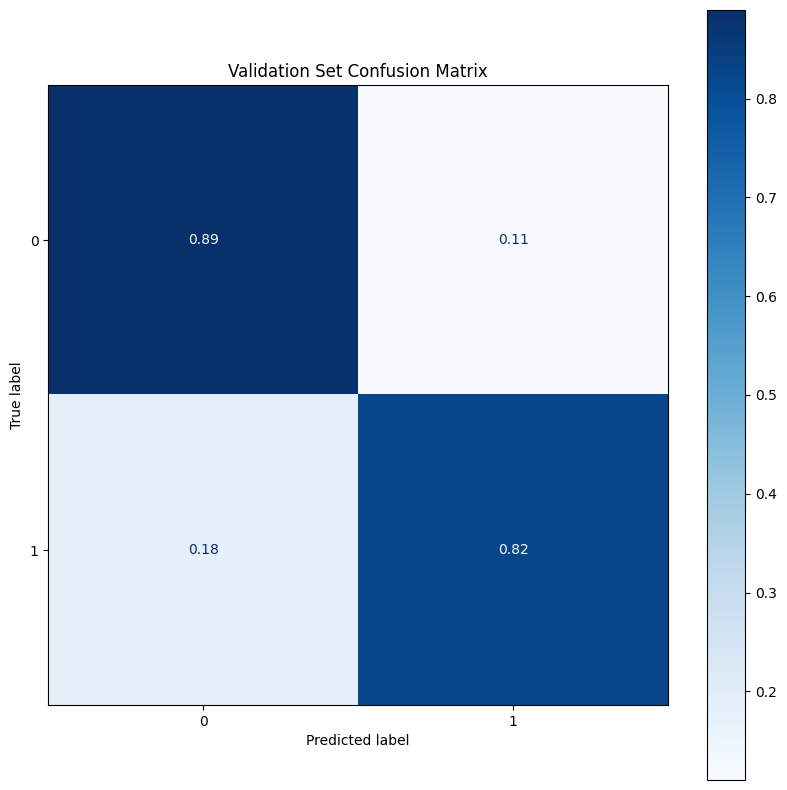

In [ ]:
plot_confusion_matrix(
    model=model,
    loader=val_loader,  # Or train_loader, test_loader, etc.
    device=device,
    num_classes=2,  # Replace with the actual number of classes
    title="Validation Set Confusion Matrix"
)
